In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np

# Load the numpy array from the file
data = np.load('training/training_data.npy')
valid_periods = np.load('training/valid_periods.npy')
categories = np.load('training/categories.npy')
data.shape

(48000, 2776)

In [5]:
new_data = []

for idx in range(len(data)):  # Use range instead of len
    start_idx = valid_periods[idx][0]

    while start_idx + 209 <= valid_periods[idx][1]:  # Adjust the condition
        # subarray of length 209 to be added to new data
        interval = data[idx, start_idx:start_idx + 209]
        new_data.append(interval)

        start_idx += 209

# Convert the list to a numpy array
newnew_data = np.array(new_data)

# Check the shape of the new data
print(data.shape)

(48000, 2776)


In [6]:
# Calculate the number of valid points for each function
num_valid_points = valid_periods[:, 1] - valid_periods[:, 0] + 1

# Filter out functions with less than 210 valid points
filtered_data = data[num_valid_points >= 210]

# Check the shape of the filtered data
print(filtered_data.shape)
data = filtered_data

(21970, 2776)


In [7]:
# Convert training_data and categories to DataFrame
data_df = pd.DataFrame(data, columns=[f'Timestep_{i+1}' for i in range(data.shape[1])])
categories_df = pd.DataFrame(categories, columns=['Category'])

# Concatenate DataFrames along the columns
df = pd.concat([data_df, categories_df], axis=1)

# Display the resulting DataFrame
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2777 entries, Timestep_1 to Category
dtypes: float64(2776), object(1)
memory usage: 1017.0+ MB


,Timestep_1,Timestep_2,Timestep_3,Timestep_4,Timestep_5,Timestep_6,Timestep_7,Timestep_8,Timestep_9,Timestep_10,...,Timestep_2767,Timestep_2768,Timestep_2769,Timestep_2770,Timestep_2771,Timestep_2772,Timestep_2773,Timestep_2774,Timestep_2775,Timestep_2776
count,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,...,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000,21970.000000
mean,0.000008,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007,0.000007,0.000007,0.000007,...,0.595932,0.604305,0.613837,0.615924,0.612213,0.612401,0.613662,0.620510,0.627669,0.627484
std,0.001237,0.001201,0.001154,0.001124,0.001119,0.001107,0.001102,0.001095,0.001095,0.001083,...,0.282408,0.283490,0.283004,0.281195,0.283854,0.286105,0.286328,0.287996,0.288089,0.289991
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.367089,0.374737,0.386136,0.391605,0.386792,0.385368,0.387692,0.389710,0.400000,0.401287
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.662281,0.676649,0.689696,0.691024,0.689320,0.689699,0.694281,0.706620,0.715241,0.714286
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.838710,0.849405,0.857273,0.859330,0.857497,0.860458,0.860899,0.868720,0.877148,0.877193
max,0.183319,0.178061,0.171051,0.166542,0.165793,0.164041,0.163324,0.162288,0.162288,0.160536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


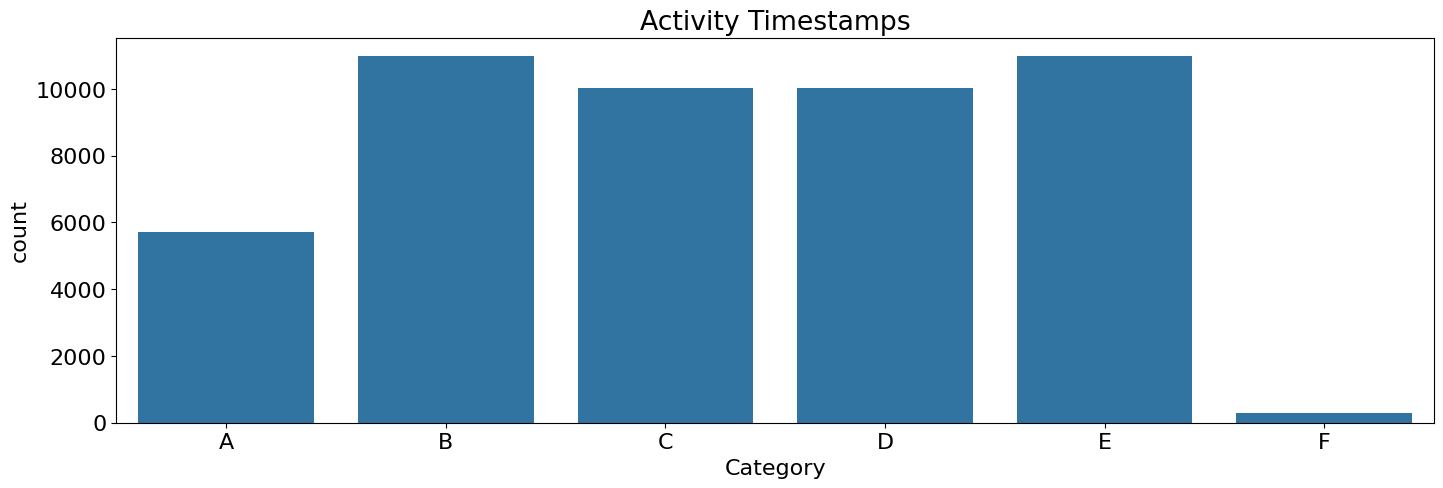

In [8]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = sorted(df['Category'].unique()))
plt.title('Activity Timestamps')
plt.show()

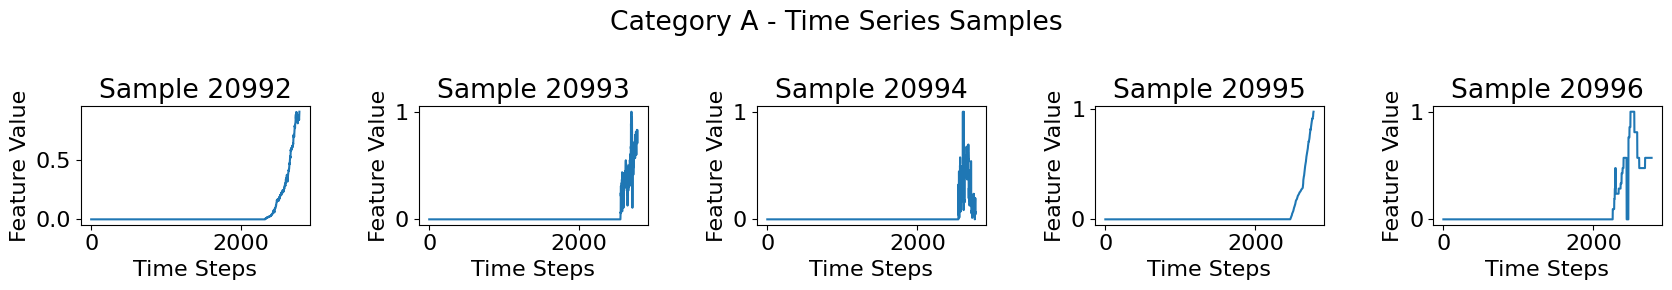

<Figure size 1700x300 with 0 Axes>

<Figure size 1700x300 with 0 Axes>

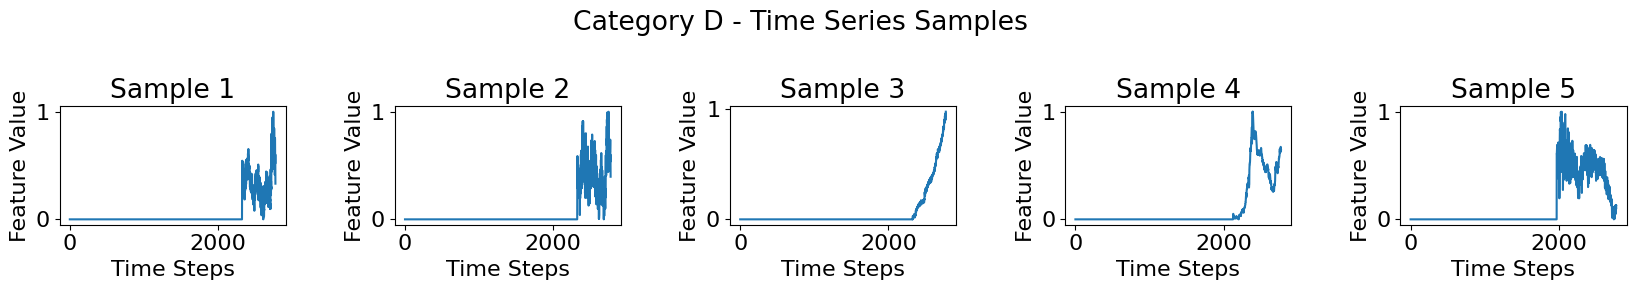

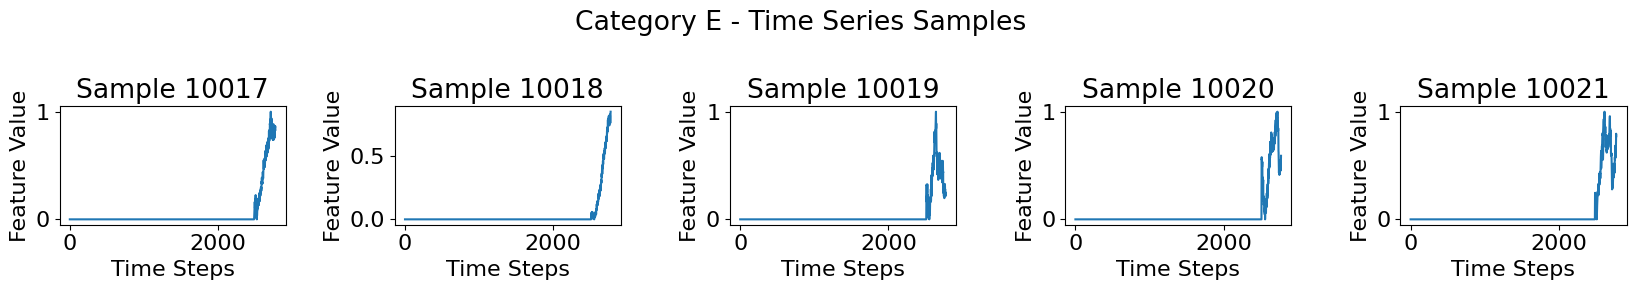

<Figure size 1700x300 with 0 Axes>

In [9]:
# Plot some samples
for category in "ABCDEF":
    to_be_inspected = 5

    plt.figure(figsize=(17, 3))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples')

    for idx in range(len(data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        plt.subplot(1, 5, 6 - to_be_inspected)  # 1 row, 5 columns, and the current plot position
        plt.plot(data[idx])
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


In [10]:
from datetime import datetime

def save_model(model, description):
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%d%m_%H%M")

    model.save('models/' + formatted_datetime + '/' + description + '.h5')

In [11]:
# Shuffle the datasets in unison
perm = np.random.permutation(data.shape[0])
data_shuffled = data[perm]
valid_periods_shuffled = valid_periods[perm]

K = 10000
# Split into training and validation sets
validation_data = data_shuffled[:K]
validation_periods = valid_periods_shuffled[:K]

training_data = data_shuffled[K:]
training_periods = valid_periods_shuffled[K:]

In [12]:
def apply_valid_periods(data, valid_periods):
    """
    Modify each function in 'data' based on the corresponding 'valid_periods'.

    Parameters:
    data (numpy.ndarray): Array of functions, shape (n_samples, n_features).
    valid_periods (numpy.ndarray): Array of valid periods, shape (n_samples, 2).

    Returns:
    numpy.ndarray: Modified data array.
    """
    modified_data = np.zeros_like(data)
    n_samples, n_features = data.shape

    for i in range(n_samples):
        left, right = valid_periods[i]
        # Assuming 'left' and 'right' are indices in the range [0, n_features-1]
        # Adjust them if they are in a different format
        modified_data[i, left:right+1] = data[i, left:right+1]

    return modified_data

# Apply the function to your datasets
modified_training_data = apply_valid_periods(training_data, training_periods)
modified_validation_data = apply_valid_periods(validation_data, validation_periods)
#modified_test_data = apply_valid_periods(test_data, test_periods)


In [13]:
num_predictions = 18

In [14]:
def extract_fixed_intervals(data, interval_length=(200 + num_predictions)):
    """
    For each function in 'data', extract a random interval of 'interval_length'.
    If a function has fewer than 'interval_length' points, pad the rest with zeros.

    Parameters:
    data (numpy.ndarray): Array of functions, shape (n_samples, n_features).
    interval_length (int): Length of the interval to extract.

    Returns:
    numpy.ndarray: Data array with fixed-size intervals extracted.
    """
    n_samples, n_features = data.shape
    modified_data = np.zeros((n_samples, interval_length))

    for i in range(n_samples):
        nonzero_indices = np.nonzero(data[i])[0]

        # Check if there are enough nonzero points
        if nonzero_indices.size >= interval_length:
            start_idx = np.random.choice(nonzero_indices[:-interval_length+1])
            end_idx = start_idx + interval_length
            modified_data[i] = data[i, start_idx:end_idx]
        else:
            # If not enough points, just copy what is available
            modified_data[i, :nonzero_indices.size] = data[i, nonzero_indices]

    return modified_data

# Apply the function to your datasets
final_training_data = extract_fixed_intervals(modified_training_data)
final_validation_data = extract_fixed_intervals(modified_validation_data)
#final_test_data = extract_fixed_intervals(modified_test_data)


In [15]:
final_training_data.shape

(11970, 218)

### With a masking layer

In [19]:
# Assuming final_training_data and final_validation_data are your datasets
# Reshape data for Transformer input
X_train = final_training_data[:, :-num_predictions]
y_train = final_training_data[:, -num_predictions:]

X_val = final_validation_data[:, :-num_predictions]
y_val = final_validation_data[:, -num_predictions:]

X_train.shape

(11970, 200)

In [20]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

# Assuming final_training_data and final_validation_data are numpy arrays
num_predictions = 18  # The number of future steps to predict
d_model = 128  # Dimensionality of the model
num_heads = 8   # Number of attention heads (d_model should be divisible by this)
ff_dim = 128    # Dimensionality of the feed-forward layer

# Your dataset creation here
X_train = final_training_data[:, :-num_predictions]
y_train = final_training_data[:, -num_predictions:]
X_val = final_validation_data[:, :-num_predictions]
y_val = final_validation_data[:, -num_predictions:]

# Ensure that input data is 3D (batch_size, timesteps, feature_dim)
X_train = X_train[..., None]  # Add the feature dimension
X_val = X_val[..., None]  # Add the feature dimension

# Transformer block as built-in keras layer
class TransformerBlock(Model):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Input layer
input_layer = Input(shape=(X_train.shape[1], 1))  # Now handling 3D data

# Transformer block layer and mask
transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
mask = None  # Masking isn't necessary if you don't have padding or aren't masking future time steps
x = transformer_block(input_layer, training=True, mask=mask)

# Output layer
x = tf.keras.layers.Flatten()(x)  # Flatten the 3D output to 2D
output_layer = Dense(num_predictions)(x)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# This is a summarization of the model you've just constructed
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 transformer_block_2 (Trans  (None, 200, 128)          24195     
 formerBlock)                                                    
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense_9 (Dense)             (None, 18)                460818    
                                                                 
Total params: 485013 (1.85 MB)
Trainable params: 485013 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
terminate_on_nan = TerminateOnNaN()
reduce_on_plateau = ReduceLROnPlateau(monitor='val_mse', mode='min', patience=5, factor=0.5, min_lr=1e-5)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.00002)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50, 
    batch_size=512,
    callbacks=[early_stopping, terminate_on_nan, learning_rate_scheduler]
).history

Epoch 1/50
24/24 [==============================] - 205s 9s/step - loss: 3.0309 - val_loss: 0.8975 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - 210s 9s/step - loss: 0.5255 - val_loss: 0.3161 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - 210s 9s/step - loss: 0.2985 - val_loss: 0.2761 - lr: 0.0010
Epoch 4/50
 9/24 [==========>...................] - ETA: 1:40 - loss: 0.2723

KeyboardInterrupt: 

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau

# Hyperparameters
d_model = 128  # Dimensionality of the model
num_heads = 64   # Number of attention heads
ff_dim = 128    # Dimensionality of the feed-forward layer

# Input layer
input_layer = Input(shape=(X_train.shape[1],))
masking_layer = tfkl.Masking(mask_value=0.0)(input_layer)

# Transformer Encoder
x = Dense(d_model, activation='relu')(masking_layer)
x = Dropout(0.1)(x)

x = Dense(ff_dim, activation='relu')(x)
x = Dropout(0.1)(x)

# Add layer normalization
x = LayerNormalization()(x)

# Output layer
output_layer = Dense(num_predictions)(x)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(lr=0.01)  # Adjust the initial learning rate
model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
terminate_on_nan = TerminateOnNaN()
reduce_on_plateau = ReduceLROnPlateau(monitor='val_mse', mode='min', patience=5, factor=0.5, min_lr=1e-5)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.00002)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=300, 
    batch_size=256,
    callbacks=[early_stopping, terminate_on_nan, learning_rate_scheduler]
).history


Epoch 1/300


KeyboardInterrupt: 

In [17]:
from sklearn.metrics import mean_squared_error

# Reshape validation data (if required)
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Predict
predictions = model.predict(X_val_reshaped)

# Calculate MSE
mse = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error: {mse}")

313/313 [==============================] - 1s 4ms/step


ValueError: Input contains NaN.

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Without a masking layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau

# Assuming final_training_data and final_validation_data are your datasets
# Reshape data for Transformer input
X_train = final_training_data[:, :-num_predictions]
y_train = final_training_data[:, -num_predictions:]

X_val = final_validation_data[:, :-num_predictions]
y_val = final_validation_data[:, -num_predictions:]

# Hyperparameters
d_model = 128  # Dimensionality of the model
num_heads = 64   # Number of attention heads
ff_dim = 128    # Dimensionality of the feed-forward layer

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# Transformer Encoder
x = Dense(d_model, activation='relu')(input_layer)
x = Dropout(0.1)(x)

x = Dense(ff_dim, activation='relu')(x)
x = Dropout(0.1)(x)

# Add layer normalization
x = LayerNormalization()(x)

# Output layer
output_layer = Dense(num_predictions)(x)

# Create and compile the model
non_mask_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(lr=0.01)  # Adjust the initial learning rate
non_mask_model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
terminate_on_nan = TerminateOnNaN()
reduce_on_plateau = ReduceLROnPlateau(monitor='val_mse', mode='min', patience=5, factor=0.5, min_lr=1e-5)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.00002)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
non_mask_history = non_mask_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=300, 
    batch_size=256,
    callbacks=[early_stopping, reduce_on_plateau, terminate_on_nan, learning_rate_scheduler]
).history


In [ ]:
from sklearn.metrics import mean_squared_error

# Reshape validation data (if required)
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Predict
predictions = non_mask_model.predict(X_val_reshaped)

# Calculate MSE
mse = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error: {mse}")

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.plot(non_mask_history['loss'], label='Training Loss')
plt.plot(non_mask_history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
save_model(model, 'withMasking_'+f'{mse}')
save_model(non_mask_model, 'withoutMasking'+f'{mse}')

### Larger epoch training

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, LearningRateScheduler

# Assuming final_training_data and final_validation_data are your datasets
# Reshape data for Transformer input
X_train = final_training_data[:, :-num_predictions]
y_train = final_training_data[:, -num_predictions:]

X_val = final_validation_data[:, :-num_predictions]
y_val = final_validation_data[:, -num_predictions:]

# Hyperparameters
d_model = 128  # Dimensionality of the model
num_heads = 64   # Number of attention heads
ff_dim = 128    # Dimensionality of the feed-forward layer

# Input layer
input_layer = Input(shape=(X_train.shape[1],))
masking_layer = tfkl.Masking(mask_value=0.0)(input_layer)

# Transformer Encoder
x = Dense(d_model, activation='relu')(masking_layer)
x = Dropout(0.1)(x)

x = Dense(ff_dim, activation='relu')(x)
x = Dropout(0.1)(x)

# Add layer normalization
x = LayerNormalization()(x)

# Output layer
output_layer = Dense(num_predictions)(x)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(lr=0.001)  # Adjust the initial learning rate
model.compile(optimizer=optimizer, loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=10, restore_best_weights=True)
terminate_on_nan = TerminateOnNaN()

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.00002)

learning_rate_scheduler = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=500, 
    batch_size=128,
    callbacks=[early_stopping, terminate_on_nan, learning_rate_scheduler]
).history


In [ ]:
from sklearn.metrics import mean_squared_error

# Reshape validation data (if required)
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Predict
predictions = model.predict(X_val_reshaped)

# Calculate MSE
mse = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error: {mse}")

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "models/SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "my_model.h5"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf

class model:
    def __init__(self, path):
        # Load the models
        self.model = tf.keras.models.load_model(os.path.join(path, 'my_model.h5'))

    def predict(self, X, categories):
        probabilities = self.model.predict(X)
        return probabilities

""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)